In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils import Config
from model import gru_model
import h5py
from tqdm import tqdm
import random
import os.path as osp
import os

import librosa


In [60]:
class mfcc_set(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = self.X[index:index+1]
        # remove dimension 0
        data = data.squeeze(0)
        label = self.y[index]
        return torch.Tensor(data), torch.Tensor(label).type(torch.LongTensor)

In [61]:
english_list = os.listdir(Config['english'])
hindi_list = os.listdir(Config['hindi'])
mandarin_list = os.listdir(Config['mandarin'])


english_test = english_list[9*len(english_list)//10:]
hindi_test = hindi_list[9*len(hindi_list)//10:]
mandarin_test = mandarin_list[9*len(mandarin_list)//10:]

In [82]:
english_ex = english_test[11]
mandarin_ex = mandarin_test[3]
hindi_ex = hindi_test[3]

mapping = {'english':0,'hindi':1,'mandarin':2}
num_feature = Config['mfcc_feature']
sequence_length = 6000

In [83]:
def mel_features(filename, thres=40):
    '''
    @param thres: The threshold (in decibels) below reference to consider as silence
    @return mfccs: np.ndarray, shape=(num_features,n_mfcc)
    '''
    y, sr = librosa.load(filename, sr=16000)
    y = librosa.core.to_mono(y)
    intervals = librosa.effects.split(y, top_db=thres)
    
    y_cons = np.zeros((0,))
    for interval in intervals:
        y_cons = np.hstack([ y_cons, y[interval[0]: interval[1]] ])
        
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft=int(sr*0.025), hop_length= int ( sr *0.010) )
    return mfccs.T

In [84]:
def process_test_non_overlap(filename, language="english"):
    mfccs = mel_features(osp.join(Config[language], filename), thres=40)    
    N_lan = mfccs.shape[0] // sequence_length
    language_mfcc = mfccs[:N_lan*sequence_length]
    language_3D = language_mfcc.reshape((N_lan, sequence_length, 64))
    
    lan_label = np.full(shape=(N_lan,sequence_length,3), fill_value=np.array([int(i == mapping[language]) for i in range(3)]))
    lan_all = np.concatenate([language_3D, lan_label],axis=2)
    return lan_all

In [30]:
def process_test_overlap(language_file, language="english"):
    mfccs = mel_features(osp.join(Config[language], language_file), thres=40) 
    language_mfcc = []
    for i in range(len(mfccs) - sequence_length + 1):
        lang_temp = mfccs[i:i+sequence_length]
        language_mfcc.append(lang_temp)
        # print(lang_temp.shape)
    language_mfcc = np.array(language_mfcc,dtype="float32")
    language_2D = np.concatenate([x for x in language_mfcc])
    print(language_2D.shape)
    N_lan = language_2D.shape[0] // sequence_length
    language_2D = language_2D[:N_lan*sequence_length]
    language_3D = language_2D.reshape((N_lan, sequence_length, 64))
    
    lan_label = np.full(shape=(N_lan,sequence_length,3), fill_value=np.array([int(i == mapping[language]) for i in range(3)]))
    # print(lan_label)
    lan_all = np.concatenate([language_3D, lan_label],axis=2)
    return lan_all

In [49]:
# depreciated
english_all_overlap = process_test_overlap(english_ex, language="english")

In [85]:
english_all = process_test_non_overlap(english_ex, language="english")
mandarin_all = process_test_non_overlap(mandarin_ex, language="mandarin")
hindi_all = process_test_non_overlap(hindi_ex, language="hindi")

english_data = english_all[:,:,:64]
english_label = english_all[:,:,-3:]
mandarin_data = mandarin_all[:,:,:64]
mandarin_label = mandarin_all[:,:,-3:]
hindi_data = hindi_all[:,:,:64]
hindi_label = hindi_all[:,:,-3:]


eng_test = mfcc_set(english_data, english_label.copy())
man_test = mfcc_set(mandarin_data, mandarin_label.copy())
hin_test = mfcc_set(hindi_data, hindi_label.copy())

eng_load = DataLoader(eng_test, batch_size=1, shuffle=False)
man_load = DataLoader(man_test, batch_size=1, shuffle=False)
hin_load = DataLoader(hin_test, batch_size=1, shuffle=False)




In [86]:
len_eng = english_data.shape[0]
len_man = mandarin_data.shape[0]
len_hin = hindi_data.shape[0]



In [87]:
model = gru_model
softmax_out = nn.Softmax(dim=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(osp.join(Config['root_path'], Config['checkpoint_path'], 'gru2.pth'))
model.load_state_dict(state_dict)


<All keys matched successfully>

In [103]:


def get_test_res(dataloader=eng_load):
    model.eval()
    count = 0
    random.seed = 11
    random_frame = random.randint(10,100)
    torch
    for x, y in dataloader:
        x = x.to(device)
        count += 1
        yhat = model(x).cpu()
        outputs = softmax_out(yhat)
        # print(outputs)
        if count == random_frame:
            outputs = outputs.view(-1,3)
            break
    return outputs

In [104]:
eng_output = get_test_res(eng_load).squeeze(0).detach().numpy()
man_output = get_test_res(man_load).squeeze(0).detach().numpy()
hin_output = get_test_res(hin_load).squeeze(0).detach().numpy()

In [105]:
import matplotlib.pyplot as plt
def plot_streaming(outputs, fname):
    plt.plot(outputs, label=["english", "hindi", "mandarin"])
    # plt.xticks([0,100,200,300,400,500,600,700,800], [0,1,2,3,4,5,6,7,8])
    plt.xlabel("10 ms")
    plt.ylabel("softmax")
    plt.legend(labels=["English", "Hindi","Mandarin"],loc='best')
    plt.title(f"{fname} streaming model")
    plt.show()
    return

In [106]:
hin_output.shape

(6000, 3)

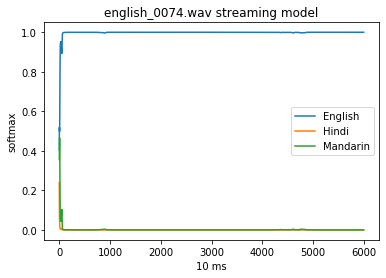

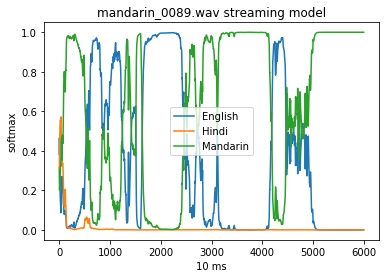

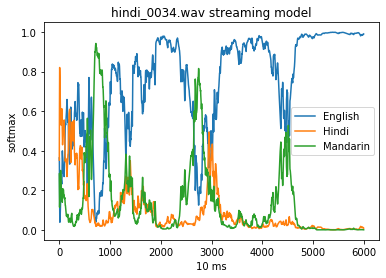

In [107]:
plot_streaming(eng_output, fname=english_ex)
plot_streaming(man_output, fname=mandarin_ex)
plot_streaming(hin_output, fname=hindi_ex)


## Experiment on not removing silence

In [41]:
def mel_features_non_split(filename, thres=40):
    '''
    @param thres: The threshold (in decibels) below reference to consider as silence
    @return mfccs: np.ndarray, shape=(num_features,n_mfcc)
    '''
    y, sr = librosa.load(filename, sr=16000)
    y = librosa.core.to_mono(y)
            
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=64, n_fft=int(sr*0.025), hop_length= int ( sr *0.010) )
    return mfccs.T

In [43]:
def process_test_non_overlap_non_split(filename, language="english"):
    mfccs = mel_features_non_split(osp.join(Config[language], filename), thres=40)    
    N_lan = mfccs.shape[0] // sequence_length
    language_mfcc = mfccs[:N_lan*sequence_length]
    language_3D = language_mfcc.reshape((N_lan, sequence_length, 64))
    
    lan_label = np.full(shape=(N_lan,sequence_length,3), fill_value=np.array([int(i == mapping[language]) for i in range(3)]))
    lan_all = np.concatenate([language_3D, lan_label],axis=2)
    return lan_all

In [47]:
english_ex_non_split = english_test[13]

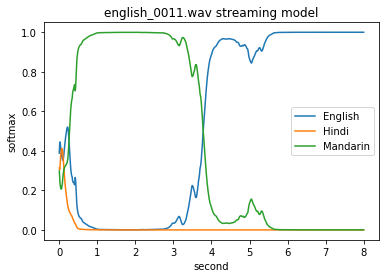

In [48]:
english_all_non_split = process_test_non_overlap_non_split(english_ex_non_split, language="english")

english_data_non_split = english_all_non_split[:,:,:64]
english_label_non_split = english_all_non_split[:,:,-3:]
eng_test_non_split = mfcc_set(english_data_non_split, english_label_non_split.copy())
eng_load_non_split = DataLoader(eng_test_non_split, batch_size=1, shuffle=False)
eng_output_non_split = get_test_res(eng_load_non_split).squeeze(0).detach().numpy()
plot_streaming(eng_output_non_split, fname=english_ex_non_split)

## Check Test Accuracy

In [93]:
with h5py.File("/mnt/hw5_test.hdf5" , 'r') as hf:
    test_data = hf['test_data'][:]
    test_label = hf['test_label'][:]
test_dataset = mfcc_set(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [94]:
### TEST
model.eval()
with torch.no_grad():
    correct = 0.0
    ## using the sequence model
    for x, y in test_loader:
        x = x.to(device)
        y = y[:,-1,:]
        y = torch.argmax(y, axis=1)
        yhat = model(x)[:,-1,:].cpu()

        correct += torch.sum(torch.argmax(yhat, axis=1)==y).double()
        test_acc = correct / len(test_loader.dataset)


In [95]:
print("Test Accuracy:", test_acc.item())

Test Accuracy: 0.6378644186863365


In [102]:
from torchsummary import summary
summary(model, (801, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 801, 64], [-1, 2, 64]]               0
            Linear-2               [-1, 801, 3]             195
Total params: 195
Trainable params: 195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 50.04
Params size (MB): 0.00
Estimated Total Size (MB): 50.24
----------------------------------------------------------------
